The goal of this report is to use Machine Learning algorithms to classify the T-Lymphocytes in two groups: T-helper and T-regulatory. To answer to this classification problem, we will follow the classical machine learning framework:

- Exploratory data analysis; 
- Feature selection;
- Model selection along with performance assessment;
- Choosing the most suitable algorithm.

## Loading the data

In [145]:
# Import the libraries
import pandas as pd
import numpy as np
from pandas import read_csv

# Loading the training data
train_df = read_csv("/Users/miradain/Desktop/Machine_Learning_Q2/ML-A5-2020_train.csv", index_col=0)

## Exploratory data analysis

- Getting the infos on the data

In [128]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, C-1 to C-1000
Columns: 23385 entries, A1BG to label
dtypes: float64(23371), int64(10), object(4)
memory usage: 178.4+ MB


The data has 1000 users and 23385 features: 8 boolean features, 23371 numerical features, 4 categorical features and 2 integer features (among those, there is the dependent variable 'label').

- Checking the group proportions in the dependant variable 

In [184]:
train_df['label'].astype(str).value_counts()

-1    885
1     115
Name: label, dtype: int64

We deduce that the data is unbalanced as there are a disproportionate ratio of observations in each class: 11.5% T-reg (+1) and 88.5% T-helper (-1). This suggest that a "majority vote" strategy can even do better than a sophisticated model if we use a naive metric. 
This kind of problem often occurs in machine learning classification and there are many ideas to solve it. Our approach will consist of changing evaluation the metric. Namely, we will consider a weighted average between the sensitivity and the specificity.

- Building the performance evaluation metric

The metric that we use in this report is the Balanced Classification Rate (BCR) 
which considers sensitivity and speficity similarly:
 $$BCR= \frac{1}{2}( \frac{TP}{TP+FN} + \frac{TN}{TN+FP} )$$
 
The above cited "majority vote" will give a score BCR $=0.5$ .


In [ ]:
from sklearn.metrics import  make_scorer
from sklearn.metrics import confusion_matrix

def BCR_fun(y_true, y_pred):
    Table_Pred_BCR = confusion_matrix(y_true, y_pred)
    n1 = Table_Pred_BCR[0,0]+Table_Pred_BCR[1,0]
    n2 = Table_Pred_BCR[1,1]+Table_Pred_BCR[0,1]
    speficity_pred = Table_Pred_BCR[0,0]/(max(n1,1))
    sensitivity_pred = Table_Pred_BCR[1,1]/(max(n2,1))
    return 1/2*(speficity_pred + sensitivity_pred)

BCR_score = make_scorer(BCR_fun, greater_is_better=False)

- Checking the proportion of missing data

In [189]:
sum(train_df.isna().sum())/(23371*1000)


0.03493072611355954

Thus the data has $\sim 3.5$% of missing data. 

- Filling the missing values of numerical features with their respective median

In [131]:
# Extract the float64 and int64 part of the data
num_train_df= train_df.loc[:,(train_df.dtypes==np.float64) | (train_df.dtypes==np.int64)]

X=train_df.fillna(num_train_df.median()).drop('label', axis=1)
y=train_df['label']

# Feature selection
## Numerical feature selection
### Removing numerical features with low variance

In [130]:
# Extract numerical and integer features
X_num_int= X.loc[:, (X.dtypes==np.float64) | (X.dtypes==np.int64)]
Covariance_matrix=X_num_int.cov()
variances= pd.DataFrame( np.diag(Covariance_matrix), index= Covariance_matrix.index, columns= ['variance'])

Before extracting the high variance features, we will make a visualisation to decide about the treshold.

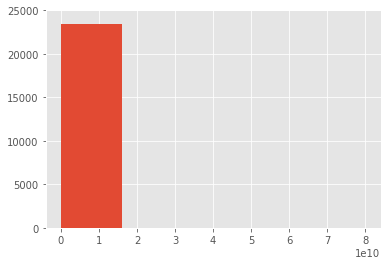

In [132]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
plt.hist(np.array(variances), 5)
plt.ylim(bottom=0, top= 25000)
plt.show()

We will consider features with variance above 7000. They are 5784.

In [133]:
Var= variances[variances.variance>=7000]
len(Var)
Numerical_Features=Var.index.values.tolist()

### Recursive feature elimination (RFE) for numeric variables

In [134]:
# recursive feature elimination (RFE)
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=988, step=50)
selector = selector.fit(X[Numerical_Features], y)

# Indices of features selected
ind = np.where(selector.support_)[0]
# New selected features
Num_Features=[Numerical_Features[i] for i in ind]

## Categorical feature selection

### Categorical variables

- We will encode categorical (object) features to numerical value features.

patient: 'Alpha'=0, 'Beta'=1, 'Gamma'= 2, 'Delta'=3, 'Epsilon'=4

tissue: 'Periferal blood'=0, 'Tumor-infiltrating'=1, 'Normal'=2

level.mito: 'High'=0, 'Normal'=1

level.ribo: 'High'=0, 'Normal'=1


In [136]:
X['patient'], uniques_patient=pd.factorize(X_cat['patient'])
X['tissue'], uniques_tissue=pd.factorize(X_cat['tissue'])
X['level.mito'], uniques_level_mito=pd.factorize(X_cat['level.mito'])
X['level.ribo'], uniques_level_ribo=pd.factorize(X_cat['level.ribo'])

- We use the ch2 method to select useful categorical variables


Feature 0: 1.875144
Feature 1: 7.912676
Feature 2: 0.635834
Feature 3: 5.311644


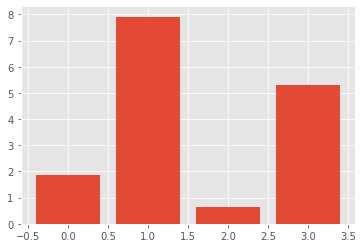

In [137]:
cat_features=['patient', 'tissue', 'level.mito', 'level.ribo']
X_catt=X[cat_features]

from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt 

fs=SelectKBest(score_func=chi2, k='all')
fs.fit(X_catt, y)

for i in range(len(fs.scores_)):
    print('Feature %d: %f' %(i, fs.scores_[i]))
    
# Plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

We will then retain from the above computation the categorical features

Cat_Features= ['tissue', 'level.ribo'].

## Boolean features selection

- We will encode boolean features to numerical value features: False=0, True=1

In [150]:

bool_cat= train_df.loc[:,train_df.dtypes==np.bool].astype(int)

-  We use the ch2 method to select useful boolean features.

The boolean features of our data set are: low.yield,	marker.A,	marker.B,	marker.C,	marker.D,	marker.E,	marker.F,	marker.G  .

Feature 0: 9.597669
Feature 1: 0.101460
Feature 2: 0.705304
Feature 3: 16.425240
Feature 4: 0.133561
Feature 5: 0.000063
Feature 6: 1.619419
Feature 7: 0.276285


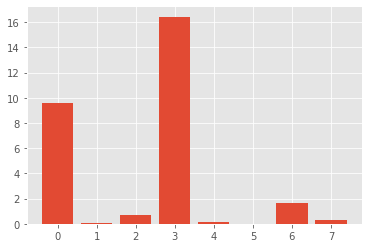

In [147]:
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt 

fs=SelectKBest(score_func=chi2, k='all')
fs.fit(bool_cat, y)

for i in range(len(fs.scores_)):
    print('Feature %d: %f' %(i, fs.scores_[i]))
    
# Plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

We will then retain from the above computation the categorical features

bool_Features= ['low.yield', 'marker.C'].

## Automating feature selection for a new input data

The data to consider after this process is the combination of the numerical, categorical and boolean selected features.

In [151]:
Features= ['low.yield', 'marker.C']+['tissue', 'level.ribo']+Numerical_Features

def transformed_data(data):
    New_data=data[Features]
    # Encode boolean features into numeric
    New_data.loc[:,New_data.dtypes==np.bool]= New_data.loc[:,New_data.dtypes==np.bool].astype(int)
    # Encode categorical features into numeric
    New_data['tissue'], uniques_tissue=pd.factorize(New_data['tissue'])
    New_data['level.ribo'], uniques_level_ribo=pd.factorize(New_data['level.ribo'])
    # Fill missing values with column median
    num_data= New_data.loc[:,(New_data.dtypes==np.float64) | (New_data.dtypes==np.int64)]
    New_data.loc[:,(New_data.dtypes==np.float64) | (New_data.dtypes==np.int64)]=num_data.fillna(num_data.median())
    return New_data
    

    
X= transformed_data(train_df)
y=train_df['label']  


/Users/miradain/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/miradain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/miradain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

# Model selection



## Random Forest model
- Tuning the model to find the best parameters

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(max_depth=1, random_state=0)

param_grid = {
    'n_estimators': [200,300,500],
    'max_features': [.5,.7],
    'bootstrap': [False, True],
    'max_depth':[3,6]
}

model_rf = GridSearchCV(estimator=clf, param_grid=param_grid,
                     scoring=BCR_score, cv=5)

model_rf.fit(X, y)
print(model_rf.best_params_)

{'bootstrap': False, 'max_depth': 6, 'max_features': 0.7, 'n_estimators': 500}


- Building the random forest model

In [155]:
from sklearn.model_selection import cross_val_score

# Building the model
rf_clf = RandomForestClassifier(max_depth=6, max_features= 0.7, random_state=0, bootstrap=False, n_estimators= 500)

# Get the score of the above built model
rf_score= cross_val_score(rf_clf, X, y, cv=10, scoring= BCR_score)

## Support vector machine model
- Tuning the model to find the best parameters

In [157]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [5, 1,2,3, 0.001, 0.01, .1, 10, 100]
}

model_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid,
                     scoring=BCR_score, cv=5)

model_svm.fit(X, y)
print(model_svm.best_params_)

{'C': 5, 'gamma': 'scale', 'kernel': 'poly'}


- Building the SVM model

In [158]:
# Building the model
svm_clf = SVC(C=5, gamma= 'scale', kernel='poly')

# Get the score of the above built model
svm_score= cross_val_score(svm_clf, X, y, cv=10, scoring= BCR_score)

## KNN model
- Tuning the model to find the best parameters

In [165]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [2,3,4,5,10,20],
    'weights': ['uniform', 'distance'],
}

model_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid,
                     scoring=BCR_score, cv=5)
model_knn.fit(X, y)
print(model_knn.best_params_)

{'n_neighbors': 10, 'weights': 'uniform'}


- Building the KNN model

In [168]:
# Building the model
knn_clf = KNeighborsClassifier(n_neighbors=10, weights= 'uniform' )

# Getting the score of the above built model
knn_score = cross_val_score(knn_clf, X, y, cv=10, scoring= BCR_score)

## Gradient Boosting model
- Tuning the model to find the best parameters

In [170]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'loss': ['deviance', 'exponential'],
    'n_estimators': [100,200,400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [1,3,6]
}



model_GB = GridSearchCV(estimator=GradientBoostingClassifier(random_state=0), param_grid=param_grid,
                     scoring=BCR_score, cv=5)
model_GB.fit(X, y)
print(model_GB.best_params_)

{'loss': 'deviance', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 100}


- Building the Gradient Boosting model

In [171]:
# Building the model
gb_clf = GradientBoostingClassifier(random_state=0, loss= 'exponential', max_depth= 6,max_features='log2', n_estimators= 100 )

# Getting the score of the above built model 
gb_score= cross_val_score(gb_clf, X, y, cv=10, scoring= BCR_score)

# Algorithms performance assessment

Now that we have built a couple of algorithms, we will now select the one that is suitable for our data.

In [173]:
Score= pd.DataFrame()
Score['Random_Forest']=rf_score
Score['SVM']=svm_score
Score['KNN']=knn_score
Score['Gradient_Boosting']=gb_score
Score.loc['mean']=Score.mean()
print(Score)

      Random_Forest     SVM     KNN  Gradient_Boosting
0         -0.671275 -0.4450 -0.4450          -0.445000
1         -0.824885 -0.4450 -0.4450          -0.444444
2         -0.644022 -0.4450 -0.4450          -0.954082
3         -0.716667 -0.4450 -0.4450          -0.445000
4         -0.685216 -0.4450 -0.4450          -0.949495
5         -0.678266 -0.4400 -0.4400          -0.440000
6         -0.647368 -0.4400 -0.4400          -0.944444
7         -0.896313 -0.4400 -0.4400          -0.944444
8         -0.742704 -0.4400 -0.4400          -0.944444
9         -0.910326 -0.4400 -0.4400          -0.944444
mean      -0.741704 -0.4425 -0.4425          -0.745580


We deduce from this plot that the best algorithm is Gradient Boosting with an expected BCR score  $\sim 0.75$ . On the other hand, the SVM and KNN algorithms perform poorly.

# Prediction

Now that we have an algorithm that suit the best with the data, we can now make the prediction for new users.


In [194]:
# Loading the data
test_df=read_csv("/Users/miradain/Desktop/Machine_Learning_Q2/ML-A5-2020_test.csv", index_col=0)

# Get the transformed data from the feature selection analysis 
test_data= transformed_data(test_df)

# Train and make the prediction
gb_clf.fit(X,y)
y_pred = pd.DataFrame(gb_clf.predict(test_data))

# Save the prediction in csv file
y_pred.to_csv("/Users/miradain/Desktop/Machine_Learning_Q2/pred.csv", index = False)

/Users/miradain/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/miradain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/miradain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Here below is the distribution of the predicted values

In [215]:
y_pred[0].astype(str).value_counts()

-1    499
1       1
Name: 0, dtype: int64

Our algorithm tends to classify almost all of the T-cell as T-helper.  

# Conclusion

The goal of this repport was to solve a machine learning classification problem. The data set had too many features (more than 23000), thefore one of the challenges part of this research was to extract the best ones suitable to deploy our model. The data was also unbalanced, so we change the evaluation metric to tacle this issue. The best model turned out to the Gradient Boosting with an expected score of 0.75 .The SVM and KNN models perform poorly and are even bad than the canonical "majority vote" strategy.

Possiple suggestion: Explore more alternative wrapper method for feature selection such as Lasso.  